In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
#import pandas_datareader as pdr
import seaborn as sns
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import dask
import xesmf as xe

In [2]:
#import dask to parallelise
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43669 instead
  warnings.warn(


In [3]:
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

In [4]:
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/ctrl_sst.nc", use_cftime=True, chunks= {"time":240})

In [5]:
def regrid_ACCESS(ds):
    #rename coords
    ds = ds.rename({"geolon_t": "longitude", "geolat_t": "latitude"})
    #create the output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop the coords on input ds
    ds_in_1deg = ds.drop({'xt_ocean', 'yt_ocean'})
    #create regridder
    regridder_1deg = xe.Regridder(ds_in_1deg, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds['sst'].chunk({'xt_ocean': -1, 'yt_ocean': -1}))
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

In [6]:
%%time
ctrl = regrid_ACCESS(ctrl_sst)

CPU times: user 11.9 s, sys: 1.73 s, total: 13.6 s
Wall time: 16.8 s


In [7]:
%%time
ctrl = ctrl.compute()

CPU times: user 3.73 s, sys: 12.6 s, total: 16.3 s
Wall time: 48.3 s


In [8]:
#get an index to calcualte the IOB
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta
def NINO34(DS):
     return ssta(DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
     
def IOBM(DS):
    return ssta(DS).sel(latitude=slice(-20, 20),longitude=slice(40, 100)).mean(['latitude', 'longitude'])
def NINO34(DS):
    return ssta(DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
#calculate the DMI
def dmi(DS):
    WTIO = ssta(DS).sel(latitude=slice(-10, 10),longitude=slice(50, 70)).mean(['latitude', 'longitude'])
    SETIO = ssta(DS).sel(latitude=slice(-10, 0),longitude=slice(90, 110)).mean(['latitude', 'longitude'])
    return (WTIO-SETIO).drop('month')

In [9]:
DMI = dmi(ctrl)

In [10]:
#get seasonality of the DMI

#create  oscilator with frequency/power of events

#postive and negative 50% of the time

#

In [11]:
DMI = DMI.to_dataset(name = "ind")

In [12]:
DMI = DMI.to_pandas()

In [24]:
mod = AutoReg(DMI, lags = 300,  old_names=False)
res1 = mod.fit()
#print(res1.summary())

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


<AxesSubplot:>

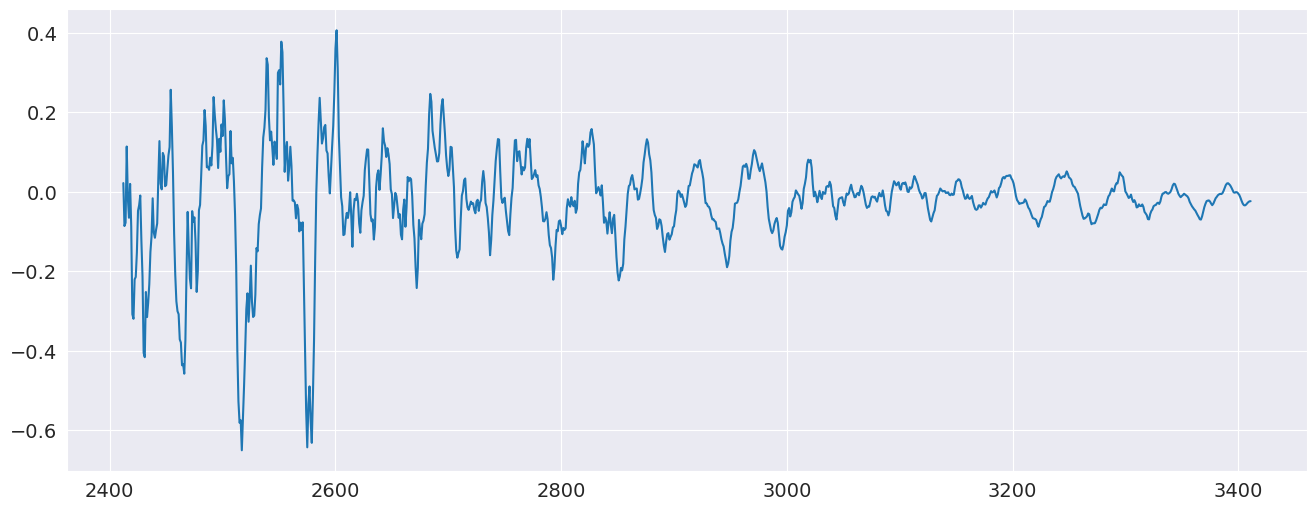

In [25]:
res1.forecast(steps = 1000).plot()

In [62]:
res2 = mod.fit(cov_type="HC0")
print(res2.summary())

                            AutoReg Model Results                             
Dep. Variable:                    ind   No. Observations:                 2412
Model:                     AutoReg(3)   Log Likelihood                  36.790
Method:               Conditional MLE   S.D. of innovations              0.238
Date:                Wed, 16 Aug 2023   AIC                            -63.580
Time:                        10:59:50   BIC                            -34.645
Sample:                             3   HQIC                           -53.055
                                 2412                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.163e-05      0.005     -0.013      0.990      -0.010       0.009
ind.L1         0.9869      0.023     42.311      0.000       0.941       1.033
ind.L2        -0.1976      0.029     -6.744      0.0

In [63]:
sel = ar_select_order(DMI, 13, seasonal=True, period=12)
sel.ar_lags

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[1, 2]

In [64]:
res3 = sel.model.fit()
print(res3.summary())

                            AutoReg Model Results                             
Dep. Variable:                    ind   No. Observations:                 2412
Model:               Seas. AutoReg(2)   Log Likelihood                  37.150
Method:               Conditional MLE   S.D. of innovations              0.238
Date:                Wed, 16 Aug 2023   AIC                            -44.299
Time:                        10:59:52   BIC                             42.511
Sample:                             2   HQIC                           -12.724
                                 2412                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.017     -0.038      0.969      -0.034       0.032
s(2,12)        0.0010      0.024      0.041      0.967      -0.046       0.048
s(3,12)        0.0006      0.024      0.027      0.9

In [80]:
DMI[300:500]

,ind
time,
0975-01-16 12:00:00,0.379335
0975-02-15 00:00:00,0.056750
0975-03-16 12:00:00,-0.632655
0975-04-16 00:00:00,-0.516945
0975-05-16 12:00:00,-0.263095
...,...
0991-04-16 00:00:00,-0.047553
0991-05-16 12:00:00,0.282499
0991-06-16 00:00:00,0.456740


In [89]:
res1.params

const    -0.000062
ind.L1    0.986862
ind.L2   -0.197643
ind.L3   -0.009060
dtype: float64

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/g/data/hh5/public/apps/miniconda3/envs/analysis

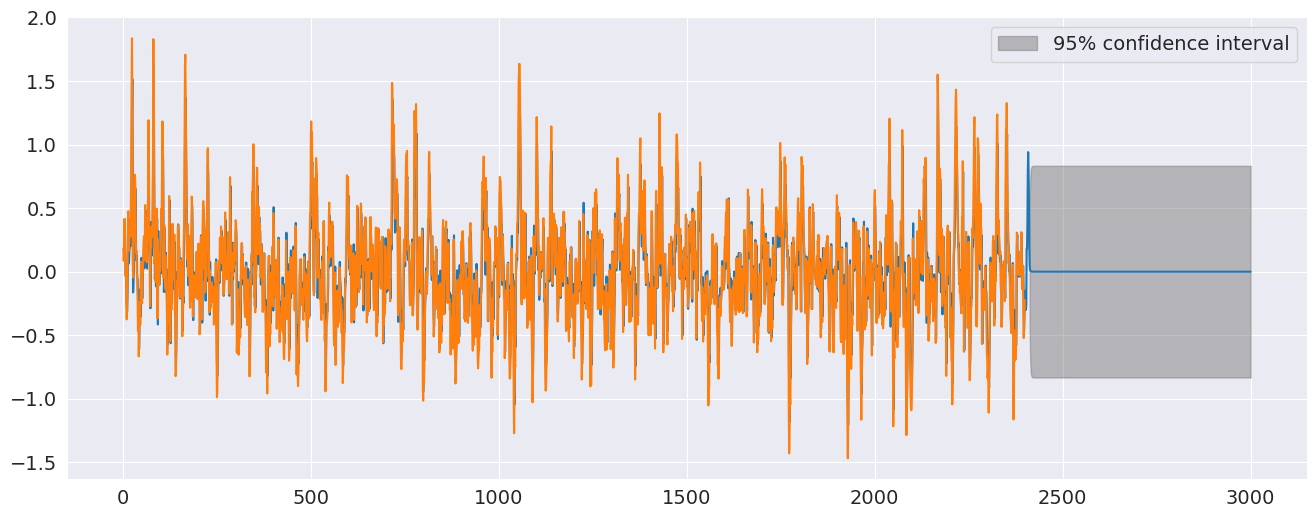

In [90]:
fig = res1.plot_predict(0, 3000)
plt.plot(DMI.ind[0:2400].values)

In [67]:
fig = res1

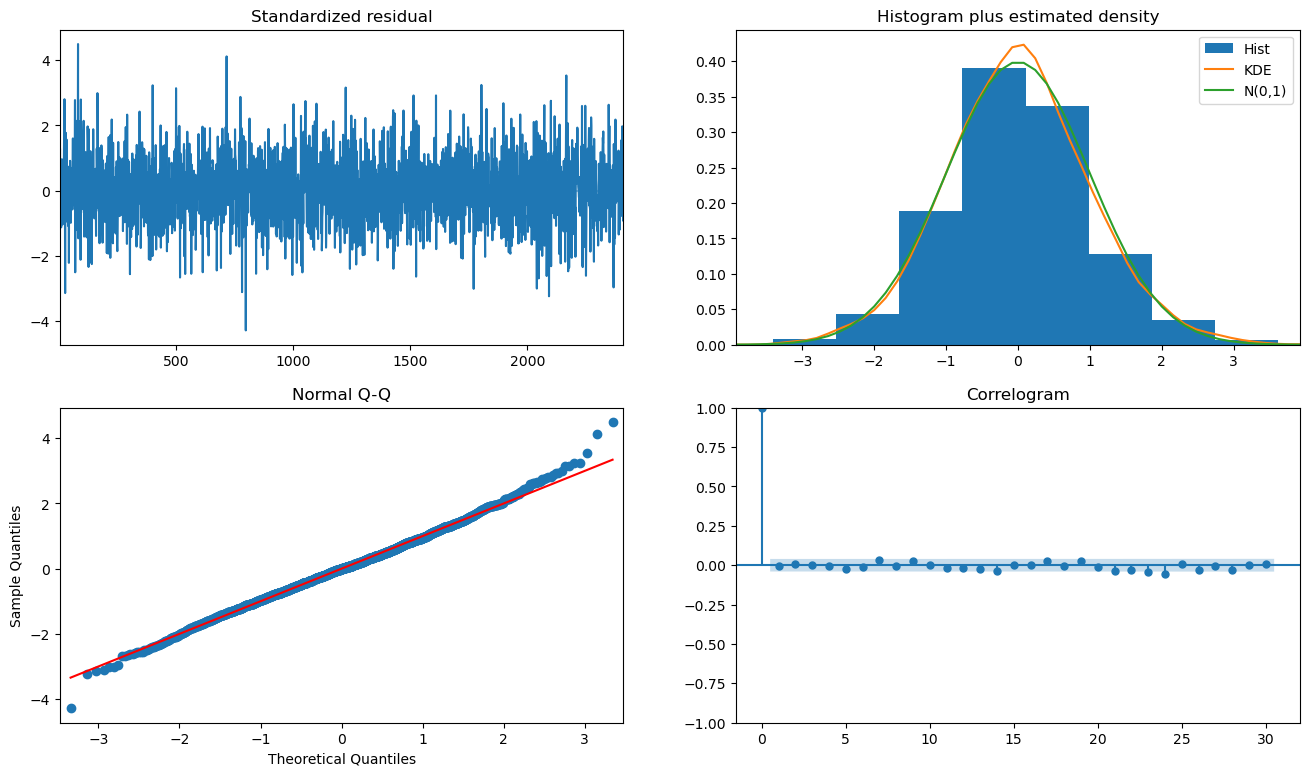

In [ ]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

<Figure size 1200x400 with 0 Axes>

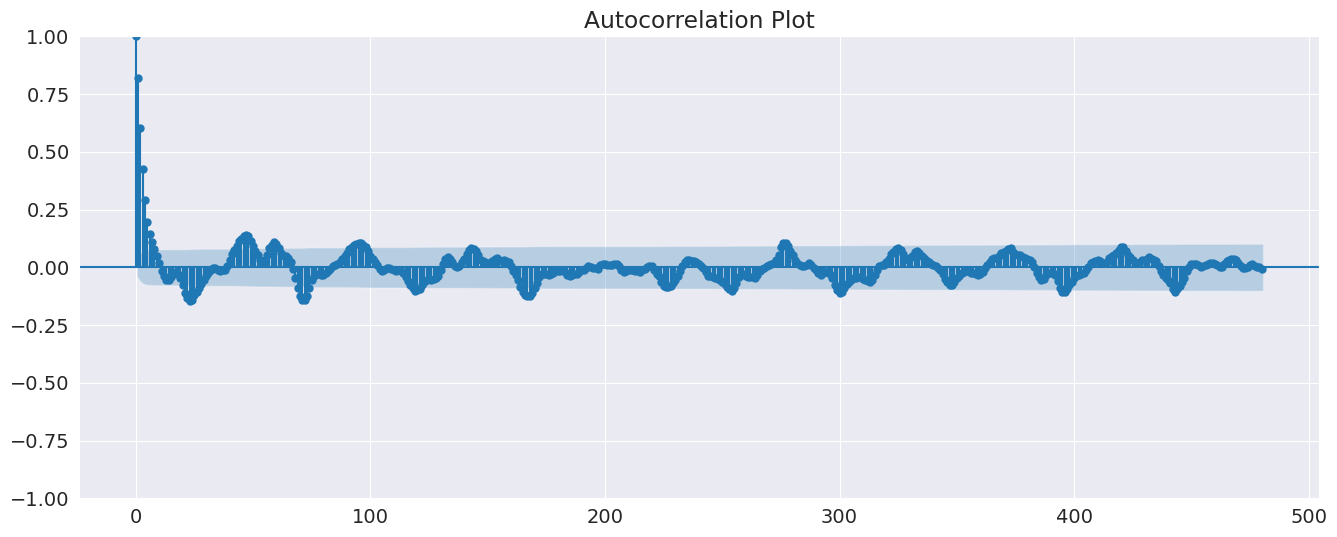

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1200x400 with 0 Axes>

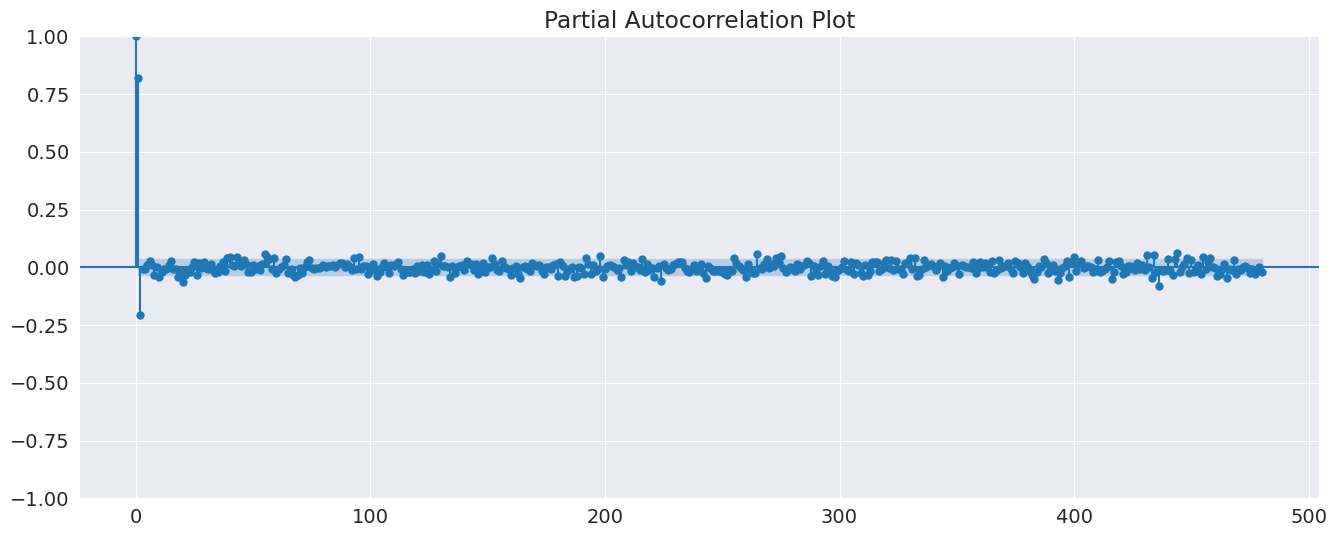

In [140]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 4))
plot_acf(DMI, lags=480, alpha = 0.05)
plt.title("Autocorrelation Plot")
plt.show()

plt.figure(figsize=(12, 4))
plot_pacf(DMI, lags=480)
plt.title("Partial Autocorrelation Plot")
plt.show()

In [92]:
import numpy as np

In [97]:
from statsmodels.tsa.ar_model import AutoReg

In [93]:
signal = np.ones(20) + 1e-6 * np.random.randn(20)

In [152]:
ar_mod = AutoReg(DMI.ind.values, lags = 300)
ar_mod1 = AutoReg(DMI.ind.values, lags = 600)


In [153]:
ar_res = ar_mod.fit()
ar_res1 = ar_mod1.fit()


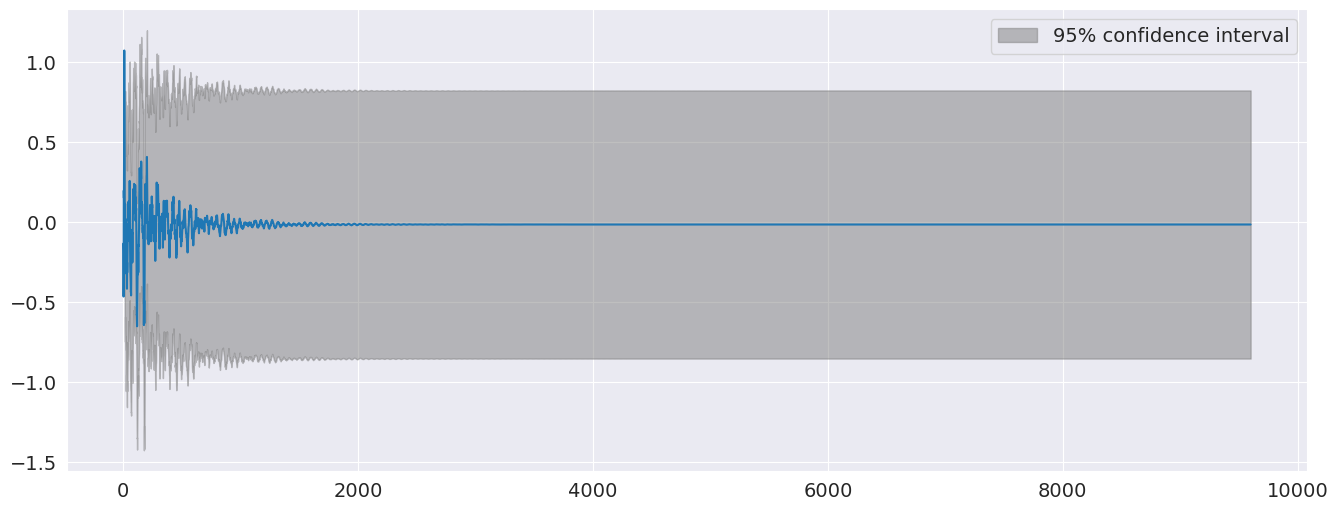

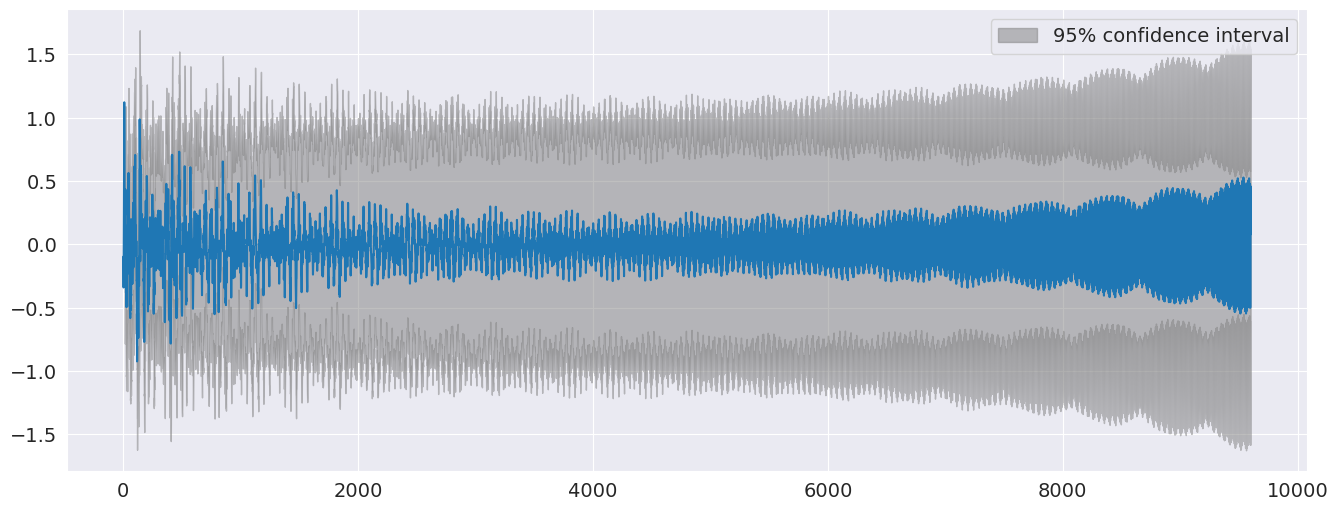

In [154]:
fig = ar_res.plot_predict(2400,12000)
fig = ar_res1.plot_predict(2400,12000)
